# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [56]:
########### Basic Parameters for Running: ################################
    
tflite_model_name_version = "7seg2312"   # Used for tflite Filename
train_val_split = 0.3                   # 0.0 = Use all Images for Training
epochs = 200

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

total_loss = np.array([])
total_val_loss = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside files are expected from NaN, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename after the correct digit at index 0 can be arbitrary

* The images are stored in x_data
* The expected category for each image is stored in y_data

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [57]:
input_dir = 'digits_resized'

files = glob.glob(input_dir + '/*.jpg')
x_data = []
y_data = []

for cur_file in files:
    base = os.path.basename(cur_file)
    target = base[0:1]
    if target == "N":
        category = 10                
    else:
        category = int(target)
    test_image = Image.open(cur_file)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if train_val_split > 0.0:
    X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=train_val_split)
else:
    X_train = x_data
    y_train = y_data
    
    X_val = np.array([])
    y_val = np.array([])

(2454, 32, 20, 3)
(2454, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [58]:
model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(32, 20, 3)), 
                             tf.keras.layers.BatchNormalization(), 
                             tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu"), 
                             tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                             tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128,activation="relu"),
                             tf.keras.layers.Dense(11, activation='softmax')])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Ba  (None, 32, 20, 3)         12        
 tchNormalization)                                               
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 20, 32)        896       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 16, 10, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 10, 32)        9248      
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 8, 5, 32)          0         
 ng2D)                                                           
                                                     

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [59]:
batch_size = 4
shift_range = 1
brightness_range = 0.3
rotation_angle = 10
zoom_range = 0.4

datagen = ImageDataGenerator(width_shift_range=[-shift_range, shift_range],
                             height_shift_range=[-shift_range, shift_range],
                             brightness_range=[1 - brightness_range, 1 + brightness_range],
                             zoom_range=[1 - zoom_range, 1 + zoom_range],
                             rotation_range=rotation_angle)

checkpoint_path = 'checkpoint/best.ckpt'
save_best_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor='val_accuracy',
                                                        mode='max',
                                                        save_best_only=True,
                                                        verbose=1)

if train_val_split > 0.0:
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    train_iterator = datagen.flow(x_data, y_data, batch_size=batch_size)
    validation_iterator = datagen.flow(X_val, y_val, batch_size=batch_size)
    history = model.fit(train_iterator, validation_data=validation_iterator, epochs=epochs, callbacks=[early_stopping_callback, save_best_callback])
else:
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    
    train_iterator = datagen.flow(x_data, y_data, batch_size=batch_size)
    history = model.fit(train_iterator, epochs=epochs, callbacks=[early_stopping_callback, save_best_callback])



Epoch 1/200
603/614 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.7680
Epoch 1: val_accuracy improved from -inf to 0.94301, saving model to checkpoint\best.ckpt
614/614 [==============================] - 3s 4ms/step - loss: 0.6352 - accuracy: 0.7706 - val_loss: 0.1514 - val_accuracy: 0.9430
Epoch 2/200
612/614 [============================>.] - ETA: 0s - loss: 0.1728 - accuracy: 0.9362
Epoch 2: val_accuracy improved from 0.94301 to 0.94573, saving model to checkpoint\best.ckpt
614/614 [==============================] - 2s 4ms/step - loss: 0.1723 - accuracy: 0.9364 - val_loss: 0.1291 - val_accuracy: 0.9457
Epoch 3/200
605/614 [============================>.] - ETA: 0s - loss: 0.1128 - accuracy: 0.9586
Epoch 3: val_accuracy improved from 0.94573 to 0.97422, saving model to checkpoint\best.ckpt
614/614 [==============================] - 2s 4ms/step - loss: 0.1115 - accuracy: 0.9588 - val_loss: 0.0703 - val_accuracy: 0.9742
Epoch 4/200
611/614 [===================

In [65]:
# Load best weights
model.load_weights(checkpoint_path)

### Learing result
 
* Visualization of the training and validation results

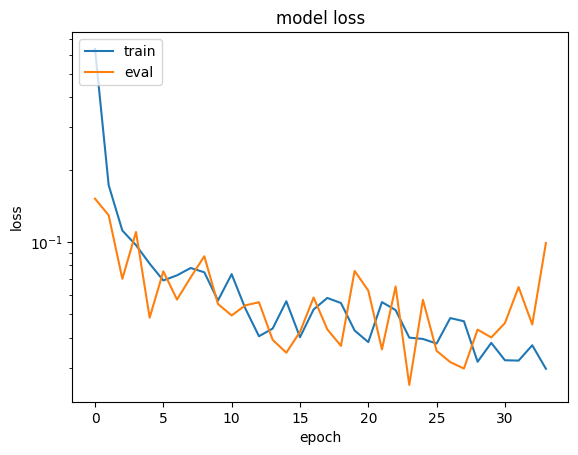

In [66]:
total_loss = np.append(total_loss, history.history['loss'])
plt.semilogy(history.history['loss'])

if train_val_split > 0:
    total_val_loss = np.append(total_val_loss, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


1/1 [==============================] - 0s 17ms/step


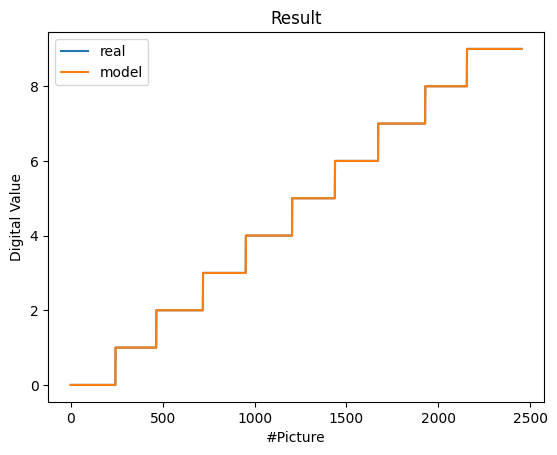

In [67]:
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(input_dir + '/*.jpg')

for cur_file in files:
    base = os.path.basename(cur_file)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(cur_file)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation:
        if str(classes) != str(expected_class):
            print(cur_file + " " + str(expected_class) + " " + str(classes))
            if show_wrong_image:
                display(image_in)
        
res = np.asarray(res)

plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(f'../models/{tflite_model_name_version}.tflite', 'wb') as h5_file:
    h5_file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpd3q4qk_4\assets


INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpd3q4qk_4\assets


In [69]:
filename = f'../models/{tflite_model_name_version}q.tflite'

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

with open(filename, 'wb') as q_file:
    q_file.write(tflite_quant_model)

Path(filename).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpjgfggl9e\assets


INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpjgfggl9e\assets
C:\Users\sebas\PycharmProjects\AI_on_the_edge_data_grabber\venv\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


62816